# JUMPER STEP BY STEP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pickle
import random

sys.path.insert(0, "../")

from lib.forecast import Predictions, Simulation, load_ts
# import importlib
# importlib.reload(jumper)

/home/ia/anaconda3/envs/nemo1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## What parameters we can change?

### Load and Prepare simulations
- path  : path of the simulation - string
- ye    : yearly average of the simulation - bool
- start : start for the training data int
- end   : end for the training data - int
- comp  : explained variance ratio - float or int

### Predictions:
- steps : Number of steps to forecast

In [2]:
path = "/home/ia/iccs_data/nemo_data_e1/"
ye = True
# start = 25
# end   = 125
start = 0
end = 20
comp = None  # default = 0.9
steps = 30

# **LOAD & PREPARE**

#### Calling the Simulation class:
- Load sea surface height, salinity and temperature
- get other attributes (see init code)

#### Calling self.prepare function
- Cut start and end
- Compute mean, std, max etc...
- Standardize default = true

In [3]:
simu_zos = Simulation(
    path=path,
    start=start,
    end=end,
    ye=ye,
    term="ssh",
    filename="DINO_1m_To_1y_grid_T.nc",  # TODO: Change to term, filename parameters
)
print("zos loaded")  # zos=ssh
simu_so = Simulation(
    path=path, start=start, end=end, ye=ye, term="soce", filename="DINO_1y_grid_T.nc"
)
print("so loaded")  # so=salinity
simu_thetao = Simulation(
    path=path, start=start, end=end, ye=ye, term="toce", filename="DINO_1y_grid_T.nc"
)
print("thetao loaded")  # thetao=temperature


simu_zos.prepare()
print("\nzos prepared")
simu_so.prepare()
print("so prepared")
simu_thetao.prepare()
print("thetao prepared")


# LoadSimu : essayer avec des chunks plus gros et plus de jobs pour 3D
# Prepare   : Cut spin Up - Remove Closed seas - Standardize - (old : Replace bathy nan values by the mean) - to float32

Using normal PCA
zos loaded
Using normal PCA
so loaded
Using normal PCA
thetao loaded

zos prepared
so prepared
thetao prepared


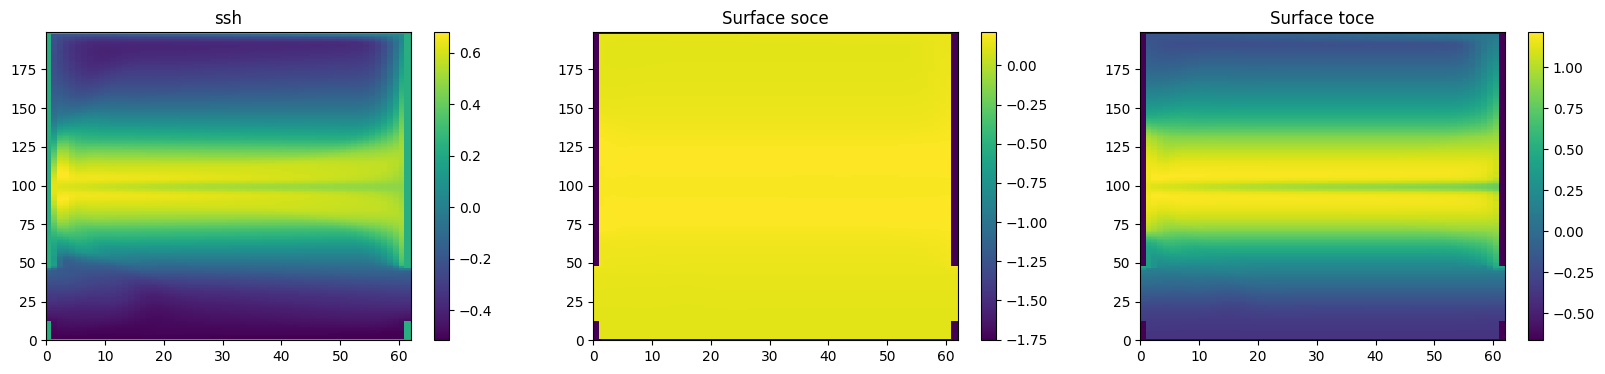

In [4]:
simus = [simu_zos, simu_so, simu_thetao]
# names = ["zos","so","thetao"]
names = ["ssh", "soce", "toce"]

fig, axes = plt.subplots(1, len(simus), figsize=(20, 4))

for i, simu in enumerate(simus):
    if simu.z_size is not None:
        im = axes[i].pcolor(simu.simulation[0, 0])
        axes[i].set_title(f"Surface {names[i]}")
    else:
        im = axes[i].pcolor(simu.simulation[0])
        axes[i].set_title(f"{names[i]}")
    plt.colorbar(im, ax=axes[i])

if False:
    fig, axes = plt.subplots(1, len(simus), figsize=(20, 4))

    for i, simu in enumerate(simus):
        if simu.z_size is not None:
            plt.plot(np.mean(simu.desc["ssca"], axis=(1, 2, 3)))
            axes[i].set_title(f"Average ssca - {names[i]}")
        else:
            plt.plot(np.mean(simu.desc["ssca"], axis=(1, 2)))
            axes[i].set_title(f"Average ssca - {names[i]}")
    plt.colorbar(im, ax=axes[i])

# **TO TIME SERIES**

#### Calling the applyPCA function:
- Compute the pca on simulation and obtain self.components and self.pca attributes

#### Calling the error function:
- Return the reconstructed simulation, rmse values and maps

#### last steps => save prepared simu and infos

In [5]:
simu_zos.decompose()
print("PCA applied on zos")
simu_so.decompose()
print("PCA applied on so")
simu_thetao.decompose()
print("PCA applied on thetao")

PCA applied on zos
PCA applied on so
PCA applied on thetao


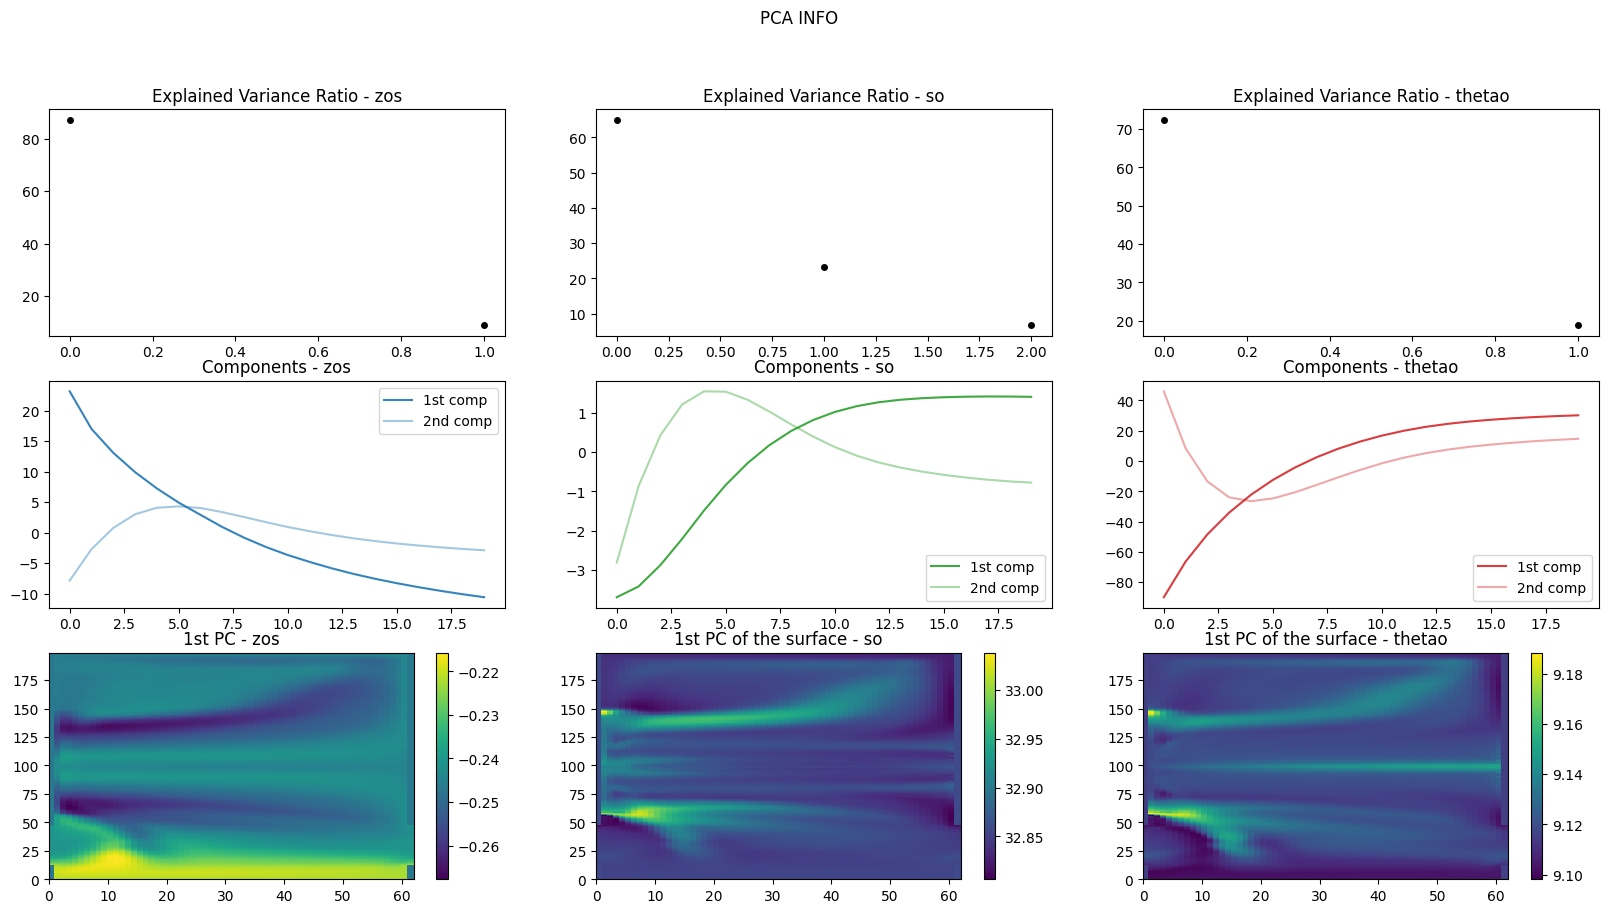

In [6]:
simus = [simu_zos, simu_so, simu_thetao]
names = ["zos", "so", "thetao"]
colors = ["tab:blue", "tab:green", "tab:red"]
fig, axes = plt.subplots(3, 3, figsize=(20, 10))

for i, simu in enumerate(simus):
    axes[0, i].plot(simu.pca.explained_variance_ratio_ * 100, "ko", markersize=4)
    axes[0, i].set_title(f"Explained Variance Ratio - {names[i]}")

    axes[1, i].plot(simu.components[:, 0], color=colors[i], alpha=0.9, label="1st comp")
    axes[1, i].plot(simu.components[:, 1], color=colors[i], alpha=0.4, label="2nd comp")
    axes[1, i].set_title(f"Components - {names[i]}")
    axes[1, i].legend()

    if simu.z_size is not None:
        im = axes[2, i].pcolor(simu.get_component(0)[0])
        plt.colorbar(im, ax=axes[2, i])  # ,label=units[i])
        axes[2, i].set_title(f"1st PC of the surface - {names[i]}")
    else:
        im = axes[2, i].pcolor(simu.get_component(0))
        plt.colorbar(im, ax=axes[2, i])  # ,label=units[i])
        axes[2, i].set_title(f"1st PC - {names[i]}")

fig.suptitle("PCA INFO")
plt.show()

In [7]:
n = len(simu_zos.pca.explained_variance_ratio_)
rec_zos, rmseV_zos, rmseM_zos = simu_zos.error(n)
print("RMSE computed for zos")
n = len(simu_so.pca.explained_variance_ratio_)
rec_so, rmseV_so, rmseM_so = simu_so.error(n)
print("RMSE computed for so")
n = len(simu_thetao.pca.explained_variance_ratio_)
rec_thetao, rmseV_thetao, rmseM_thetao = simu_thetao.error(n)
print("RMSE computed for thetao")

RMSE computed for zos
RMSE computed for so
RMSE computed for thetao


In [8]:
import xarray as xr

array = xr.open_dataset(
    simu_so.files[-1], decode_times=False, chunks={"time": 200, "x": 120}
)

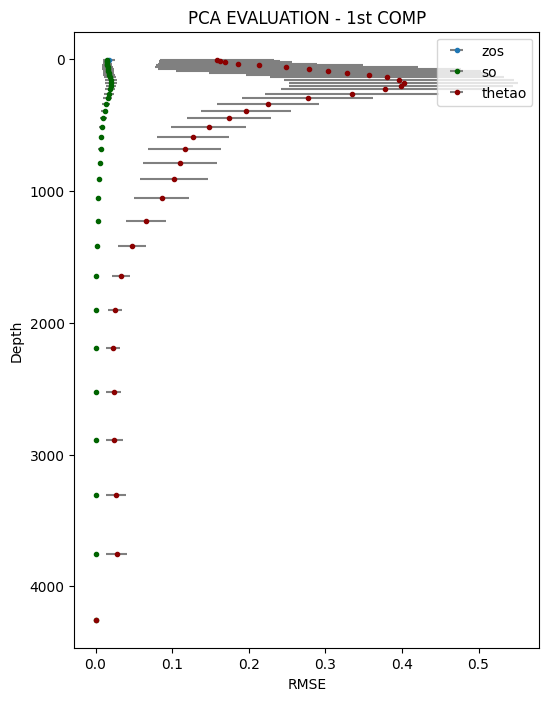

In [9]:
rmseV_zos
values = [rmseV_zos, rmseV_so.T, rmseV_thetao.T]
maps = [rmseM_zos, rmseM_so, rmseM_thetao]
names = ["zos", "so", "thetao"]
colors = ["tab:blue", "darkgreen", "darkred"]

fig = plt.figure(figsize=(6, 8))
for i in range(3):
    if i == 0:
        plt.errorbar(
            np.mean(values[i]),
            array.deptht[0],
            xerr=np.std(values[i]),
            fmt=".",
            label=names[i],
            color=colors[i],
            ecolor="grey",
        )
    else:
        plt.errorbar(
            np.mean(values[i], axis=1),
            array.deptht,
            xerr=np.std(values[i], axis=1),
            fmt=".",
            label=names[i],
            color=colors[i],
            ecolor="grey",
        )

plt.title("PCA EVALUATION - 1st COMP")
plt.ylabel("Depth")
plt.xlabel("RMSE")
plt.legend()

plt.gca().invert_yaxis()
plt.show()

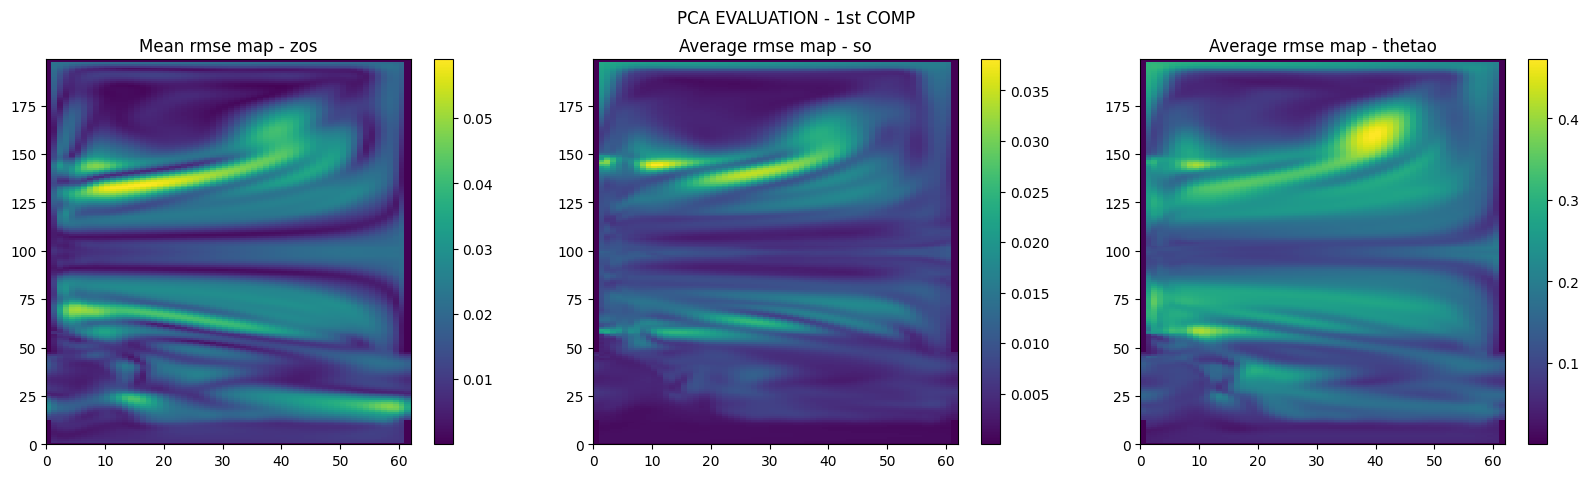

In [10]:
values = [rmseV_zos, rmseV_so, rmseV_thetao]
maps = [rmseM_zos, rmseM_so, rmseM_thetao]
names = ["zos", "so", "thetao"]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i in range(3):
    if len(np.shape(maps[i])) == 2:
        im = axes[i].pcolor(maps[i])
        plt.colorbar(im, ax=axes[i])
        axes[i].set_title(f"Mean rmse map - {names[i]}")
    else:
        im = axes[i].pcolor(np.nanmean(maps[i], axis=0))
        plt.colorbar(im, ax=axes[i])
        axes[i].set_title(f"Average rmse map - {names[i]}")

fig.suptitle("PCA EVALUATION - 1st COMP")
plt.show()

In [11]:
zos_dico = simu_zos.makeDico()
print("zos to dictionnary")
so_dico = simu_so.makeDico()
print("so to dictionnary")
thetao_dico = simu_thetao.makeDico()
print("thetao to dictionnary")

zos to dictionnary
so to dictionnary
thetao to dictionnary


In [12]:
# f = "/data/mtissot/spinup_data/simus_prepared/"
f = path
if not os.path.exists(f):
    os.makedirs(f)

with open(f + "pca_so", "wb") as file:
    pickle.dump(simu_so.pca, file)
with open(f + "pca_thetao", "wb") as file:
    pickle.dump(simu_thetao.pca, file)
with open(f + "pca_zos", "wb") as file:
    pickle.dump(simu_zos.pca, file)

np.savez(f + "so", **so_dico)
np.savez(f + "thetao", **thetao_dico)
np.savez(f + "zos", **zos_dico)

# **FORECAST**

#### Calling the load_ts function:
- get all components in a panda dataframe

#### Calling Predictions class:
- Get components, gp etc...

#### Calling Forecats function: 
- Compute forecast_ts for each time series

#### Calling reconstruct function: 
- reconstruct predictions and train predictions

In [13]:
# f = "/data/mtissot/spinup_data/simus_prepared/"
f = path

df_zos, infos_zos = load_ts(f, "zos")  # TODO: Change terms? zos, so, thetao?
df_so, infos_so = load_ts(f, "so")
df_thetao, infos_thetao = load_ts(f, "thetao")

random.seed(20)

ts_zos = Predictions("zos", df_zos, infos_zos)
ts_so = Predictions("so", df_so, infos_so)
ts_thetao = Predictions("thetao", df_thetao, infos_thetao)

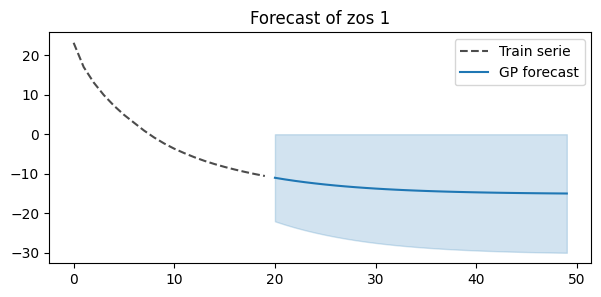

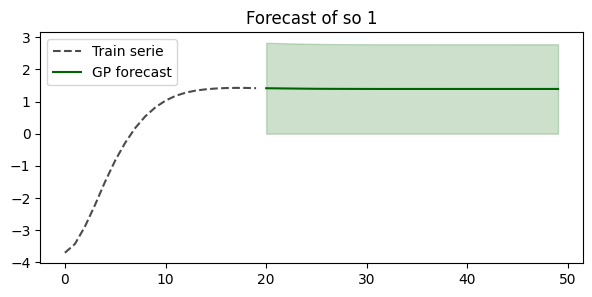

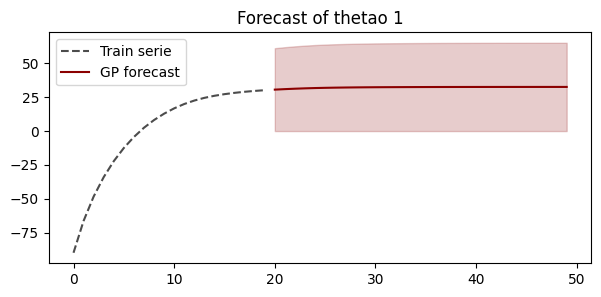

In [14]:
import random

random.seed(100)
# comp,train_len,steps=1,len(ts_zos),30#,20#len(ts_zos),30
comp, train_len, steps = 1, len(ts_zos), steps  # ,20#len(ts_zos),30


hat_zos, std_zos, metrics_zos = ts_zos.forecast_ts(
    comp, train_len, steps
)  # TODO: Check restart script change where I returned the simu?
hat_so, std_so, metrics_so = ts_so.forecast_ts(comp, train_len, steps)
hat_thetao, std_thetao, metrics_thetao = ts_thetao.forecast_ts(comp, train_len, steps)

ts_zos.show(comp, hat_zos, std_zos, train_len)
ts_so.show(comp, hat_so, std_so, train_len, color="darkgreen")
ts_thetao.show(comp, hat_thetao, std_thetao, train_len, color="darkred")

In [15]:
hat_zos, hat_std_zos, metrics = ts_zos.Forecast(train_len, steps)
hat_so, hat_std_so, metrics = ts_so.Forecast(train_len, steps)
hat_thetao, hat_std_thetao, metrics = ts_thetao.Forecast(train_len, steps)


# Utile de remettre la serie temporelle initiale pour l'analyse des erreurs
# hat_zos[:-30] = df_zos[:]
# hat_so[:-30] = df_so[:]
# hat_thetao[:-30] = df_thetao[:]

# Change due to forecasting only unknown and not the whole time series
# hat_zos[:-steps] = df_zos[:]
# hat_so[:-steps] = df_so[:]
# hat_thetao[:-steps] = df_thetao[:]
# Change
print(df_zos)
print(df_zos.shape)
print("hat zos")
print(hat_zos)
print(hat_zos.shape)

hat_zos[:end] = df_zos[:]
hat_so[:end] = df_so[:]
hat_thetao[:end] = df_thetao[:]

        zos-1     zos-2
0   23.187754 -7.853286
1   17.024265 -2.702990
2   13.096553  0.779187
3    9.927856  3.020658
4    7.252707  4.091613
5    4.928030  4.313872
6    2.917787  4.042231
7    0.923618  3.366853
8   -0.829003  2.567308
9   -2.352729  1.721565
10  -3.670516  0.928079
11  -4.798441  0.242671
12  -5.833242 -0.378031
13  -6.753602 -0.919112
14  -7.563550 -1.381505
15  -8.290163 -1.774417
16  -8.945250 -2.109793
17  -9.543571 -2.404376
18 -10.090230 -2.663504
19 -10.588299 -2.887006
(20, 2)
hat zos
        zos-1     zos-2
0  -11.042893 -3.080989
1  -11.455836 -3.251912
2  -11.830001 -3.403705
3  -12.168276 -3.537550
4  -12.474104 -3.654198
5  -12.750965 -3.756392
6  -13.001394 -3.846919
7  -13.227576 -3.927009
8  -13.431501 -3.997238
9  -13.615039 -4.058596
10 -13.780040 -4.112543
11 -13.928243 -4.160243
12 -14.061303 -4.202252
13 -14.180739 -4.239022
14 -14.287899 -4.271240
15 -14.383982 -4.299625
16 -14.470067 -4.324667
17 -14.547143 -4.346666
18 -14.616121 -4.365936


In [16]:
# CHANGER PRENDRE SERIE TEMP TRUTH + PRED
n = np.shape(ts_zos.info["ts"])[1]
predictions_zos = ts_zos.reconstruct(hat_zos, n)
print("zos reconstructed with all comp")

n = np.shape(ts_so.info["ts"])[1]
predictions_so = ts_so.reconstruct(hat_so, n)
print("so reconstructed with all comp")

n = np.shape(ts_thetao.info["ts"])[1]
predictions_thetao = ts_thetao.reconstruct(hat_thetao, n)
print("thetao reconstructed with all comp")

zos reconstructed with all comp
so reconstructed with all comp
thetao reconstructed with all comp


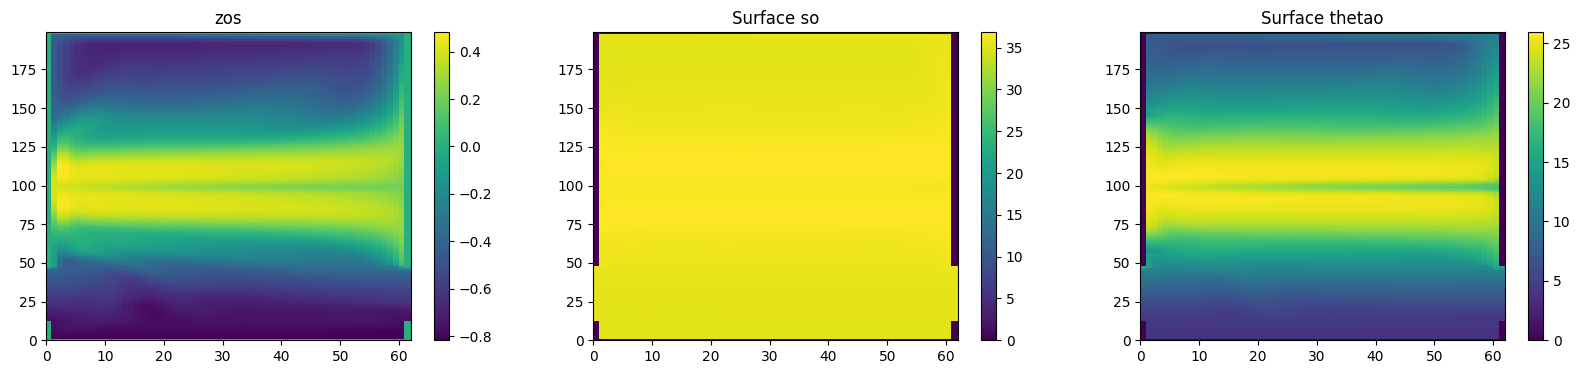

In [17]:
maps = [predictions_zos, predictions_so, predictions_thetao]
names = ["zos", "so", "thetao"]

fig, axes = plt.subplots(1, len(maps), figsize=(20, 4))

for i, simu in enumerate(maps):
    if len(np.shape(simu)) > 3:
        im = axes[i].pcolor(simu[0, 0])
        axes[i].set_title(f"Surface {names[i]}")
    else:
        im = axes[i].pcolor(simu[0])
        axes[i].set_title(f"{names[i]}")
    plt.colorbar(im, ax=axes[i])

# **SAVE PREDICTIONS**

In [18]:
np.save(path + "simu_predicted/pred_zos.npy", predictions_zos)
np.save(path + "simu_predicted/pred_so.npy", predictions_so)
np.save(path + "simu_predicted/pred_thetao.npy", predictions_thetao)

# **EVALUATE ERROR**

In [19]:
import sys

sys.path.insert(0, "../lib/")

# import forecast
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from lib.forecast import Predictions, Simulation, load_ts
# import importlib
# importlib.reload(p1)

In [20]:
pred_zos = np.load(path + "simu_predicted/pred_zos.npy")
pred_so = np.load(path + "simu_predicted/pred_so.npy")
pred_thetao = np.load(path + "simu_predicted/pred_thetao.npy")

In [21]:
# id_,start2,end2 ="106",25,125+30#start,end+steps
id_, start2, end2 = "106", start, end + steps  # start,end+steps


ye = False
# path ="/scratchu/mtissot/SIMUp6Y"
# simu_zos = Simulation(
#     path=path, start=start, end=end, ye=ye, term="ssh", filename="DINO_1m_To_1y_grid_T.nc" # TODO: Change to term, filename parameters
# )
ref_zos = Simulation(
    path=path,
    start=start2,
    end=end2,
    ye=ye,
    term="ssh",
    filename="DINO_1m_To_1y_grid_T.nc",
)
print("zos loaded")
ref_so = Simulation(
    path=path, start=start2, end=end2, ye=ye, term="soce", filename="DINO_1y_grid_T.nc"
)
print("so loaded")
ref_thetao = Simulation(
    path=path, start=start2, end=end2, ye=ye, term="toce", filename="DINO_1y_grid_T.nc"
)
print("thetao loaded")

# REMTTRE BIEN GET DATA APRES      return grid[:1] => return grid
ref_zos.prepare(stand=False)
print("\nzos prepared")
ref_so.prepare(stand=False)
print("so prepared")
ref_thetao.prepare(stand=False)
print("thetao prepared")

Using normal PCA
zos loaded
Using normal PCA
so loaded
Using normal PCA
thetao loaded

zos prepared
so prepared
thetao prepared


In [22]:
array = xr.open_dataset(
    ref_so.files[-1], decode_times=False, chunks={"time": 200, "x": 120}
)
depth = array.deptht
del array

#### ERREUR PREDICTIONS

In [23]:
print(ref_so.simulation[end:].shape)

err_so = np.abs((ref_so.simulation[end:] - pred_so))
err_thetao = np.abs((ref_thetao.simulation[end:] - pred_thetao))
err_zos = np.abs((ref_zos.simulation[end:] - pred_zos))

# predictions
i = 15
mean_err_so_pred = np.nanmean(err_so[-i:], axis=(0, 2, 3))
std_err_so_pred = np.nanstd(err_so[-i:], axis=(0, 2, 3))

mean_err_thetao_pred = np.nanmean(err_thetao[-i:], axis=(0, 2, 3))
std_err_thetao_pred = np.nanstd(err_thetao[-i:], axis=(0, 2, 3))

mean_err_zos_pred = np.nanmean(err_zos[-i:], axis=(0, 1, 2))
std_err_zos_pred = np.nanstd(err_zos[-i:], axis=(0, 1, 2))

# reference, what does the value of i mean?
i = 30
mean_err_so_ref = np.nanmean(err_so[:-i], axis=(0, 2, 3))
std_err_thetao_ref = np.nanstd(err_so[:-i], axis=(0, 2, 3))

mean_err_thetao_ref = np.nanmean(err_thetao[:-i], axis=(0, 2, 3))
std_err_so_ref = np.nanstd(err_thetao[:-i], axis=(0, 2, 3))

mean_err_zos_ref = np.nanmean(err_zos[:-i], axis=(0, 1, 2))
std_err_zos_ref = np.nanstd(err_zos[:-i], axis=(0, 1, 2))

(30, 36, 199, 62)


[np.float32(0.07333845), np.float32(nan)]


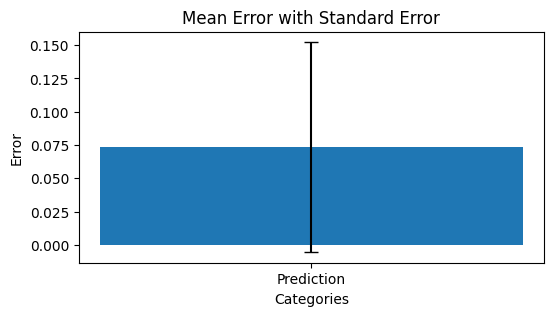

In [24]:
categories = ["Prediction", "PCA"]
means = [mean_err_zos_pred, mean_err_zos_ref]
print(means)
errors = [std_err_zos_pred, std_err_zos_ref]

fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(categories, means, yerr=errors, capsize=5, color=["tab:blue", "grey"])

ax.set_title("Mean Error with Standard Error")
ax.set_ylabel("Error")
ax.set_xlabel("Categories")
plt.show()

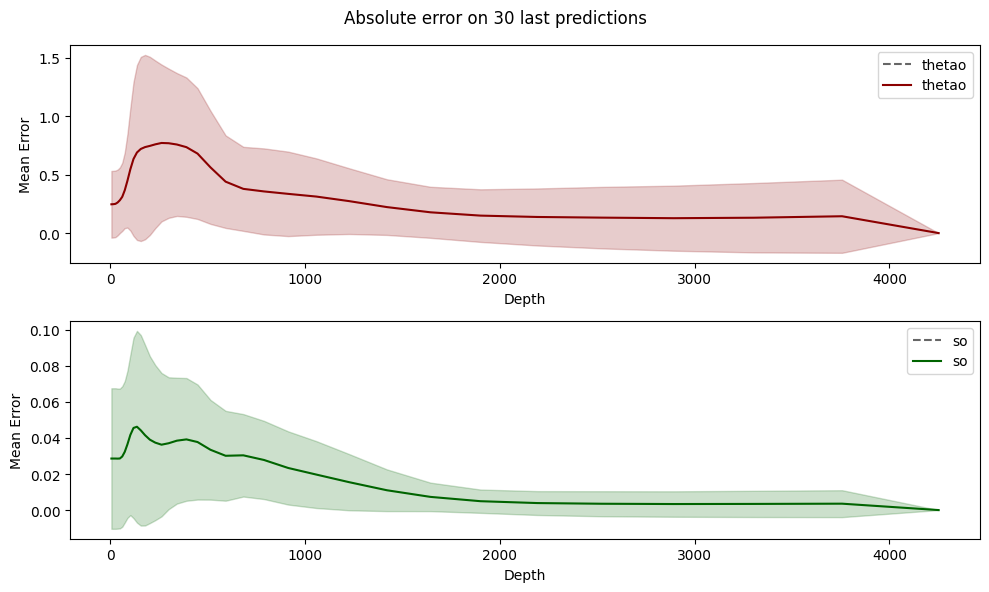

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# Plot thetao infos
axes[0].plot(
    depth,
    mean_err_thetao_ref,
    color="black",
    label="thetao",
    linestyle="dashed",
    alpha=0.6,
)
axes[0].fill_between(
    depth,
    mean_err_thetao_ref + std_err_thetao_ref,
    mean_err_thetao_ref - std_err_thetao_ref,
    color="black",
    alpha=0.1,
)

axes[0].plot(depth, mean_err_thetao_pred, color="darkred", label="thetao")
axes[0].fill_between(
    depth,
    mean_err_thetao_pred + std_err_thetao_pred,
    mean_err_thetao_pred - std_err_thetao_pred,
    color="darkred",
    alpha=0.2,
)
axes[0].set_xlabel("Depth")
axes[0].set_ylabel("Mean Error")
axes[0].legend()

# Plot so infos
axes[1].plot(
    depth, mean_err_so_ref, color="black", label="so", linestyle="dashed", alpha=0.6
)
axes[1].fill_between(
    depth,
    mean_err_so_ref + std_err_so_ref,
    mean_err_so_ref - std_err_so_ref,
    color="black",
    alpha=0.1,
)

axes[1].plot(depth, mean_err_so_pred, color="darkgreen", label="so")
axes[1].fill_between(
    depth,
    mean_err_so_pred + std_err_so_pred,
    mean_err_so_pred - std_err_so_pred,
    color="darkgreen",
    alpha=0.2,
)
axes[1].set_xlabel("Depth")
axes[1].set_ylabel("Mean Error")
axes[1].legend()

fig.suptitle(f"Absolute error on {i} last predictions")
plt.tight_layout()
plt.show()

In [26]:
mean_pred_so = np.nanmean(pred_so, axis=(1, 2, 3))
mean_ref_so = np.nanmean(ref_so.simulation, axis=(1, 2, 3))

mean_pred_thetao = np.nanmean(pred_thetao, axis=(1, 2, 3))
mean_ref_thetao = np.nanmean(ref_thetao.simulation, axis=(1, 2, 3))

mean_pred_zos = np.nanmean(pred_zos, axis=(1, 2))
mean_ref_zos = np.nanmean(ref_zos.simulation, axis=(1, 2))

depth shape:  (36,)
mean_pred_so shape:  (30,)


ValueError: x and y must have same first dimension, but have shapes (36,) and (30,)

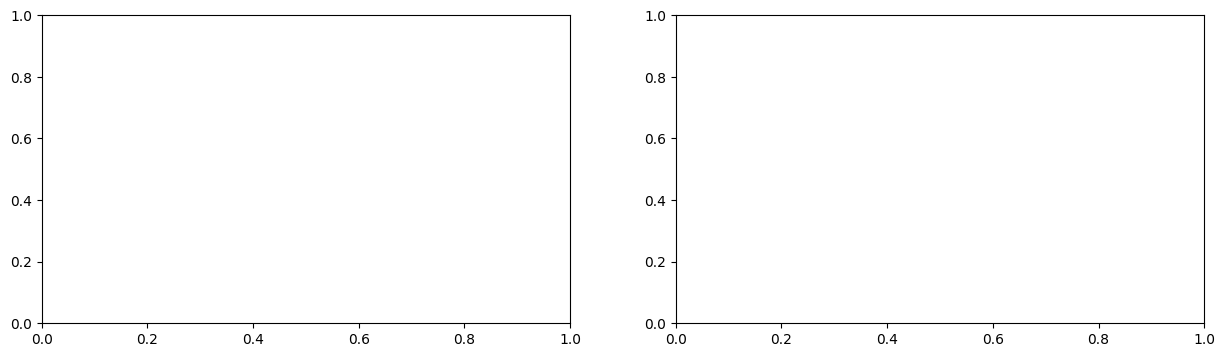

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
print("depth shape: ", depth.shape)
print("mean_pred_so shape: ", mean_pred_so.shape)
axes[0].plot(depth, mean_pred_so, label="predictions")
axes[0].plot(depth, mean_ref_so, label="reference")
axes[0].legend()

axes[1].plot(depth, mean_pred_thetao, label="predictions")
axes[1].plot(depth, mean_ref_thetao, label="reference")
axes[1].legend()

fig.suptitle("Average over depth")
plt.tight_layout()
plt.show()

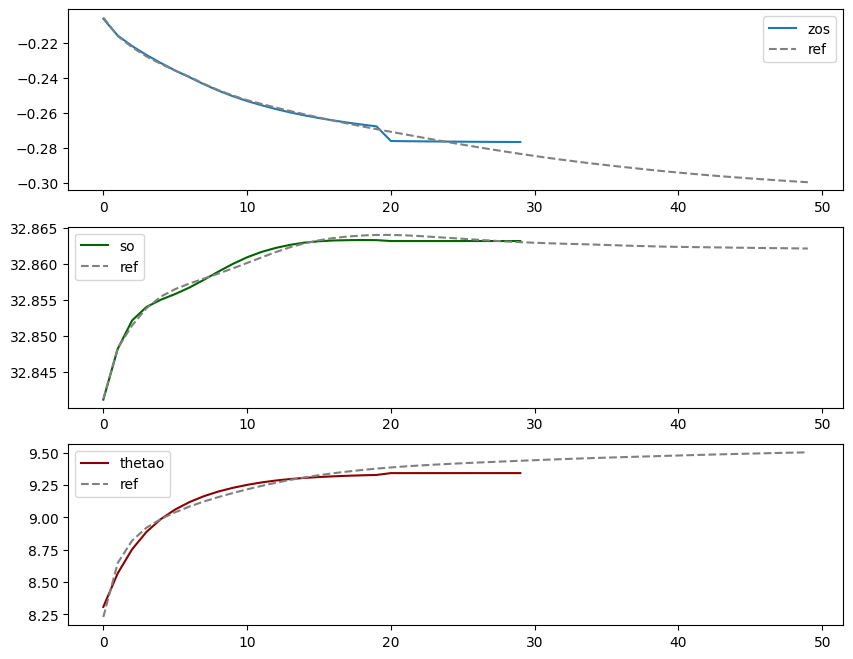

In [28]:
mean_pred = [mean_pred_zos, mean_pred_so, mean_pred_thetao]
mean_ref = [mean_ref_zos, mean_ref_so, mean_ref_thetao]
names = ["zos", "so", "thetao"]
colors = ["tab:blue", "darkgreen", "darkred"]

fig, axes = plt.subplots(3, 1, figsize=(10, 8))
for i, ax in enumerate(axes):
    ax.plot(mean_pred[i], color=colors[i], label=names[i])
    ax.plot(mean_ref[i], color="grey", label="ref", linestyle="dashed")
    ax.legend()

### Evaluate time series Predictions

In [29]:
ref_zos.simulation = (ref_zos.simulation - ref_zos.desc["mean"]) / (
    2 * ref_zos.desc["std"]
)
ref_so.simulation = (ref_so.simulation - ref_so.desc["mean"]) / (2 * ref_so.desc["std"])
ref_thetao.simulation = (ref_thetao.simulation - ref_thetao.desc["mean"]) / (
    2 * ref_thetao.desc["std"]
)

ref_zos.decompose()
print("PCA applied on zos")
ref_so.decompose()
print("PCA applied on so")
ref_thetao.decompose()
print("PCA applied on thetao")

PCA applied on zos
PCA applied on so
PCA applied on thetao


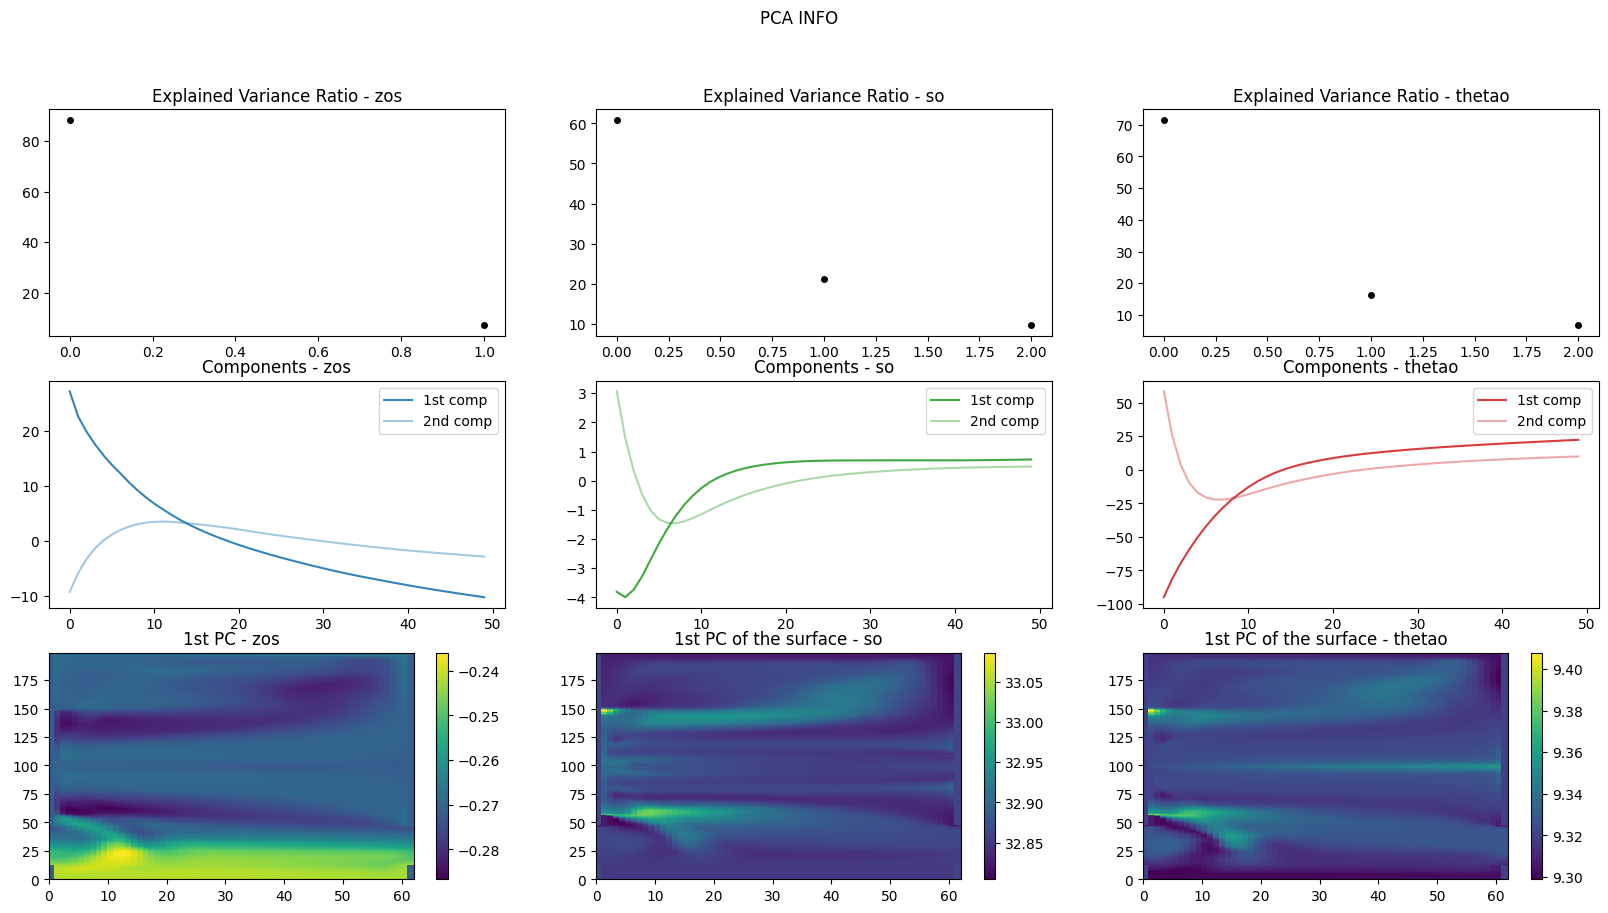

In [31]:
simus = [ref_zos, ref_so, ref_thetao]
names = ["zos", "so", "thetao"]
colors = ["tab:blue", "tab:green", "tab:red"]
fig, axes = plt.subplots(3, 3, figsize=(20, 10))

for i, simu in enumerate(simus):
    axes[0, i].plot(simu.pca.explained_variance_ratio_ * 100, "ko", markersize=4)
    axes[0, i].set_title(f"Explained Variance Ratio - {names[i]}")

    axes[1, i].plot(simu.components[:, 0], color=colors[i], alpha=0.9, label="1st comp")
    axes[1, i].plot(simu.components[:, 1], color=colors[i], alpha=0.4, label="2nd comp")
    axes[1, i].set_title(f"Components - {names[i]}")
    axes[1, i].legend()

    if simu.z_size is not None:
        im = axes[2, i].pcolor(simu.get_component(0)[0])
        plt.colorbar(im, ax=axes[2, i])  # ,label=units[i])
        axes[2, i].set_title(f"1st PC of the surface - {names[i]}")
    else:
        im = axes[2, i].pcolor(simu.get_component(0))
        plt.colorbar(im, ax=axes[2, i])  # ,label=units[i])
        axes[2, i].set_title(f"1st PC - {names[i]}")

fig.suptitle("PCA INFO")
plt.show()

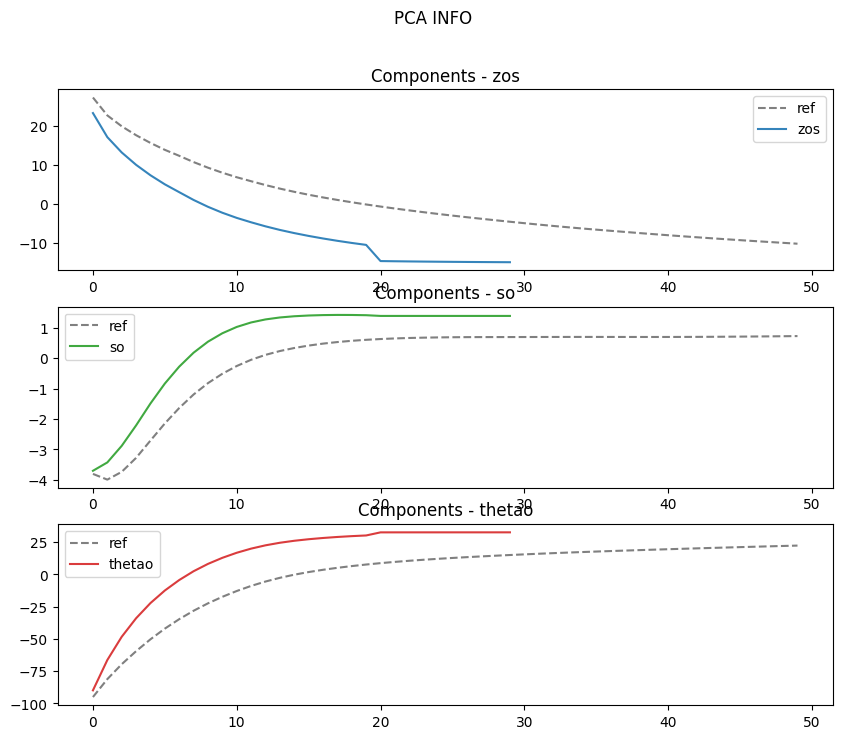

In [32]:
comp = 0
ref = [ref_zos, ref_so, ref_thetao]
pred = [hat_zos, hat_so, hat_thetao]  # [df_zos,df_so,df_thetao]
names = ["zos", "so", "thetao"]
colors = ["tab:blue", "tab:green", "tab:red"]

fig, axes = plt.subplots(3, 1, figsize=(10, 8))

for i, simu in enumerate(ref):
    axes[i].plot(
        simu.components[:, comp], color="grey", linestyle="dashed", label="ref"
    )
    axes[i].plot(pred[i].iloc[:, comp], color=colors[i], alpha=0.9, label=names[i])
    axes[i].set_title(f"Components - {names[i]}")
    axes[i].legend()

fig.suptitle("PCA INFO")
plt.show()

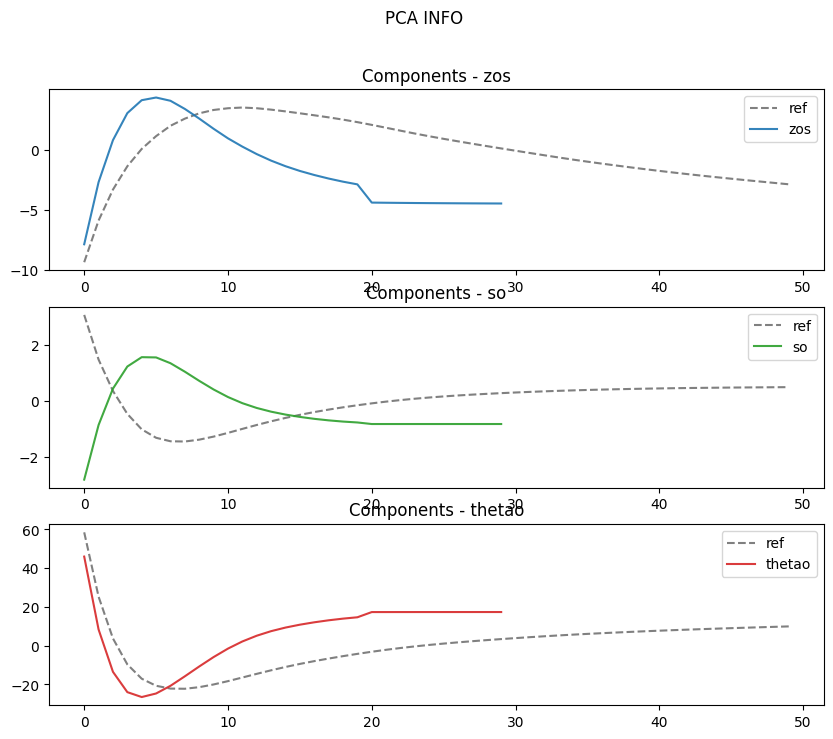

In [33]:
comp = 1

fig, axes = plt.subplots(3, 1, figsize=(10, 8))

for i, simu in enumerate(ref):
    axes[i].plot(
        simu.components[:, comp], color="grey", linestyle="dashed", label="ref"
    )
    axes[i].plot(pred[i].iloc[:, comp], color=colors[i], alpha=0.9, label=names[i])
    axes[i].set_title(f"Components - {names[i]}")
    axes[i].legend()

fig.suptitle("PCA INFO")
plt.show()

IndexError: index 2 is out of bounds for axis 1 with size 2

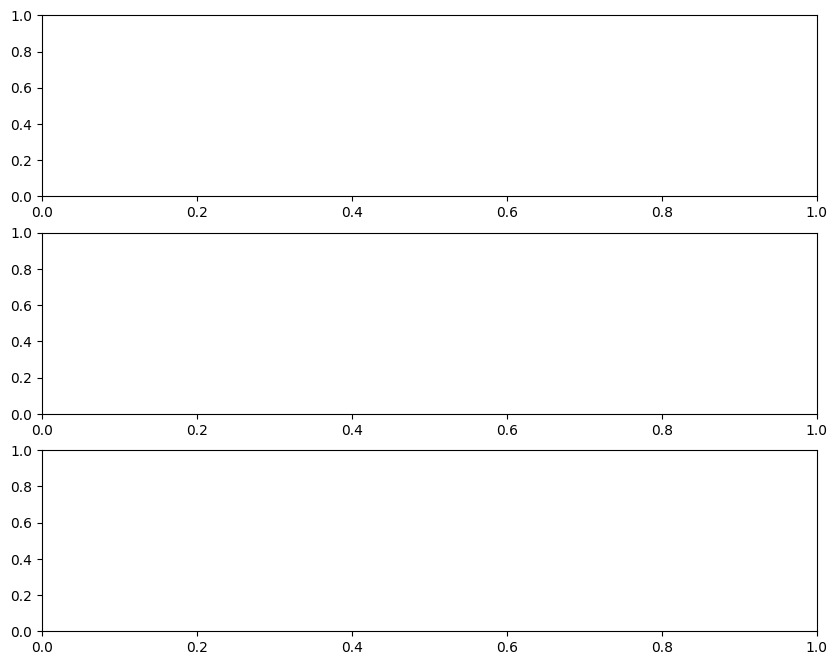

In [34]:
comp = 2

fig, axes = plt.subplots(3, 1, figsize=(10, 8))

for i, simu in enumerate(ref):
    axes[i].plot(
        simu.components[:, comp], color="grey", linestyle="dashed", label="ref"
    )
    axes[i].plot(pred[i].iloc[:, comp], color=colors[i], alpha=0.9, label=names[i])
    axes[i].set_title(f"Components - {names[i]}")
    axes[i].legend()

fig.suptitle("PCA INFO")
plt.show()